In [2]:
import numpy as np
import pandas as pd

# sklearn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Time
from datetime import datetime

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Other models
import xgboost as xgb

# Conversions
import re

# Iterators
import itertools

# Warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Options
sns.set_style('darkgrid')
pd.set_option('display.precision', 2)
plt.rcParams['figure.figsize'] = (10, 5)

In [4]:
features = pd.read_csv('features.csv')
stores = pd.read_csv('stores.csv')
dataset = pd.read_csv('train.csv')

### EDA of stores

In [5]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [6]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [7]:
for column in stores.columns:
    print(column, stores[column].nunique())

Store 45
Type 3
Size 40


No missing data

In [8]:
for column in stores.columns:
    print(column, stores[column].isnull().sum())

Store 0
Type 0
Size 0


In [9]:
stores['Type'].unique()

array(['A', 'B', 'C'], dtype=object)

In [10]:
stores['Type'].value_counts()
# Slightly imbalanced data - store C is underrepresented. No stratification required, however.

A    22
B    17
C     6
Name: Type, dtype: int64

In [11]:
# We don't seem to have outliers with respect to size
stores['Size'].sort_values().unique()

array([ 34875,  37392,  39690,  39910,  41062,  42988,  57197,  70713,
        93188,  93638, 103681, 112238, 114533, 118221, 119557, 120653,
       123737, 125833, 126512, 128107, 140167, 151315, 152513, 155078,
       155083, 158114, 184109, 196321, 200898, 202307, 202505, 203007,
       203742, 203750, 203819, 204184, 205863, 206302, 207499, 219622])

Later on in the process, we can consider binning the Size feature into sub-categories. Will help with efficiency of the model. However, need to test an effect it has on performance.

### EDA of features - to combine later in the process

In [12]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.57,NaN,NaN,NaN,NaN,NaN,211.10,8.11,False
1,1,2010-02-12,38.51,2.55,NaN,NaN,NaN,NaN,NaN,211.24,8.11,True
2,1,2010-02-19,39.93,2.51,NaN,NaN,NaN,NaN,NaN,211.29,8.11,False
3,1,2010-02-26,46.63,2.56,NaN,NaN,NaN,NaN,NaN,211.32,8.11,False
4,1,2010-03-05,46.50,2.62,NaN,NaN,NaN,NaN,NaN,211.35,8.11,False


In [13]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [14]:
features['Unemployment'].nunique()

404

In [15]:
for column in features.columns:
    print(column, features[column].isnull().sum())

Store 0
Date 0
Temperature 0
Fuel_Price 0
MarkDown1 4158
MarkDown2 5269
MarkDown3 4577
MarkDown4 4726
MarkDown5 4140
CPI 585
Unemployment 585
IsHoliday 0


In [16]:
CPI_missing = round(features['CPI'].isnull().sum()/len(features)*100,1)
Unemployment_missing = round(features['Unemployment'].isnull().sum()/len(features)*100,1)

print(f'Percentage of datapoints missing for CPI: {CPI_missing}%')
print(f'Percentage of datapoints missing for Unemployment: {Unemployment_missing}%')

Percentage of datapoints missing for CPI: 7.1%
Percentage of datapoints missing for Unemployment: 7.1%


We can see that we have a lot of missing values for MarkDown features. This means we will either need to do value imputation, or drop the features. Alternatively, we can use algorithms such as Boosting that can handle missing values through Default Direction instead of a static handling. Since only around 7% of data points are missing for CPI and Unemployment, we can consider doing mean value imputation. However, need to check if they tend to be missing for specific locations, and maybe do regression. 

TODO: Check if CPI and Unemployment tend to be missing for specific locations

In [17]:
features['MarkDown1'].nunique()

4023

In [18]:
price_reductions = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']

for element in price_reductions:
    print(features[features['IsHoliday'] == True][element].isnull().sum())

271
318
286
301
270


Let's convert Date feature into datetime format

In [19]:
features['Date'] = features['Date'].apply(lambda _: datetime.strptime(_,"%Y-%m-%d"))
type(features['Date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [20]:
dates = np.sort(features['Date'].unique())
print(f'Earliest date: {dates[0]}')
print(f'Latest date: {dates[-1]}')

Earliest date: 2010-02-05T00:00:00.000000000
Latest date: 2013-07-26T00:00:00.000000000


In [21]:
features['Date'].nunique()

182

There seem to be no outliers in the Dates column.

### EDA dataset

In [22]:
dataset.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [23]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [24]:
for column in dataset.columns:
    print(column, dataset[column].nunique())

Store 45
Dept 81
Date 143
Weekly_Sales 359464
IsHoliday 2


In [25]:
# No missing values
for column in dataset.columns:
    print(column, dataset[column].isnull().sum())

Store 0
Dept 0
Date 0
Weekly_Sales 0
IsHoliday 0


In [26]:
print(dataset['Store'].unique())
print(dataset['Dept'].unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 40 41 42 44 45 46 47 48 49 51 52
 54 55 56 58 59 60 67 71 72 74 77 78 79 80 81 82 83 85 87 90 91 92 93 94
 95 96 97 98 99 39 50 43 65]


The above Store and Dept values are just ids, and hence we will need to create categorical vairables from them using one hot encoding, as the actual value is unlikely to mean anything.

In [27]:
unique_types = set(type(x) for x in dataset['Date'])
print(unique_types)

{<class 'str'>}


In [28]:
dataset['Date'] = dataset['Date'].apply(lambda _: datetime.strptime(_,"%Y-%m-%d"))
type(dataset['Date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [29]:
unique_types = set(type(x) for x in dataset['Weekly_Sales'])
print(unique_types)

{<class 'float'>}


In [30]:
dataset.head(2)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True


In [31]:
np.sort(dataset['Weekly_Sales'])

array([ -4988.94,  -3924.  ,  -1750.  , ..., 630999.19, 649770.18,
       693099.36])

We can see that some of the values have negative weekly sales, which shouldn't be the case. Let's investigate it further.

In [32]:
# The upper boundary is fine
[f'{value:,.0f}' for value in np.sort(dataset['Weekly_Sales'])[-10:]]

['393,705',
 '404,245',
 '406,989',
 '420,587',
 '422,306',
 '474,330',
 '627,963',
 '630,999',
 '649,770',
 '693,099']

In [33]:
# Need to exclude negative numbers
[f'{value:,.0f}' for value in np.sort(dataset['Weekly_Sales'])[:20]]

['-4,989',
 '-3,924',
 '-1,750',
 '-1,699',
 '-1,321',
 '-1,098',
 '-1,098',
 '-1,098',
 '-1,009',
 '-898',
 '-863',
 '-798',
 '-798',
 '-798',
 '-798',
 '-778',
 '-772',
 '-705',
 '-698',
 '-698']

In [34]:
dataset[dataset['Weekly_Sales'] < 0]

,Store,Dept,Date,Weekly_Sales,IsHoliday
846,1,6,2012-08-10,-139.65,False
2384,1,18,2012-05-04,-1.27,False
6048,1,47,2010-02-19,-863.00,False
6049,1,47,2010-03-12,-698.00,False
6051,1,47,2010-10-08,-58.00,False
...,...,...,...,...,...
419597,45,80,2010-02-12,-0.43,True
419598,45,80,2010-02-19,-0.27,False
419603,45,80,2010-04-16,-1.61,False
419614,45,80,2010-07-02,-0.27,False


In [35]:
percentage_negative_sales = round(len(dataset[dataset['Weekly_Sales'] < 0])/len(dataset)*100,2)
print(f'Percentage of data with negative sales: {percentage_negative_sales}%')

Percentage of data with negative sales: 0.3%


In [36]:
sales = []
for department in dataset['Dept'].unique():
    department_sales = dataset[dataset['Dept'] == department]['Weekly_Sales'].sum()
    sales.append((department,department_sales))
    #print(f'{department}, {department_sales:,.0f}')

sales.sort(key = lambda x: x[1])
sales[:5]


[(47, -4962.9299999999985),
 (43, 14.32),
 (39, 177.98),
 (78, 1714.71),
 (51, 30572.83)]

Department 47 generated way more losses than any other department. Doesn't seem like coincidence. However, performance is much better when we exclude negative numbers from the dataset. Even if they relate to returns or refunds, we will ignore them for now.

In [37]:
dataset = dataset[dataset['Weekly_Sales'] >= 0]

Making sure that extra holiday dates are included

Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

In [38]:
extra_holidays = ['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08','2010-09-10','2011-09-09','2012-09-07','2013-09-06','2010-11-26','2011-11-25','2012-11-23',
                  '2013-11-29','2010-12-31','2011-12-30','2012-12-28','2013-12-27']
extra_holidays = pd.to_datetime(extra_holidays)
extra_holidays

DatetimeIndex(['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08',
               '2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06',
               '2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29',
               '2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27'],
              dtype='datetime64[ns]', freq=None)

In [39]:
dataset[dataset['Date'].isin(extra_holidays)].groupby(['IsHoliday']).count()

,Store,Dept,Date,Weekly_Sales
IsHoliday,,,,
True,29563,29563,29563,29563


In [40]:
features[features['Date'].isin(extra_holidays)].groupby(['IsHoliday']).count()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
IsHoliday,,,,,,,,,,,
True,585,585,585,585,314,267,299,284,315,585,585


In [41]:
print(dataset[dataset['Weekly_Sales'] == 0])
print(len(dataset[dataset['Weekly_Sales'] == 0]))

        Store  Dept       Date  Weekly_Sales  IsHoliday
6055        1    47 2011-03-11           0.0      False
6059        1    47 2011-08-12           0.0      False
6060        1    47 2011-08-19           0.0      False
16309       2    47 2012-04-13           0.0      False
17457       2    60 2010-03-19           0.0      False
...       ...   ...        ...           ...        ...
403340     43    85 2012-01-13           0.0      False
407652     44    27 2011-01-14           0.0      False
417805     45    47 2011-02-11           0.0       True
418079     45    54 2010-10-15           0.0      False
418150     45    54 2012-08-31           0.0      False

[73 rows x 5 columns]
73


Dealing with date

In [42]:
type(dataset['Date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [43]:
dataset['year'] = dataset['Date'].apply(lambda _: _.year)
dataset['month'] = dataset['Date'].apply(lambda _: _.month)
dataset['day_of_month'] = dataset['Date'].apply(lambda _: _.day)

In [44]:
dataset.head(10)

,Store,Dept,Date,Weekly_Sales,IsHoliday,year,month,day_of_month
0,1,1,2010-02-05,24924.50,False,2010,2,5
1,1,1,2010-02-12,46039.49,True,2010,2,12
2,1,1,2010-02-19,41595.55,False,2010,2,19
3,1,1,2010-02-26,19403.54,False,2010,2,26
4,1,1,2010-03-05,21827.90,False,2010,3,5
5,1,1,2010-03-12,21043.39,False,2010,3,12
6,1,1,2010-03-19,22136.64,False,2010,3,19
7,1,1,2010-03-26,26229.21,False,2010,3,26
8,1,1,2010-04-02,57258.43,False,2010,4,2
9,1,1,2010-04-09,42960.91,False,2010,4,9


### Visual representation of the dataset

In [45]:
dataset['year'].value_counts()

2011    152970
2010    140289
2012    127026
Name: year, dtype: int64

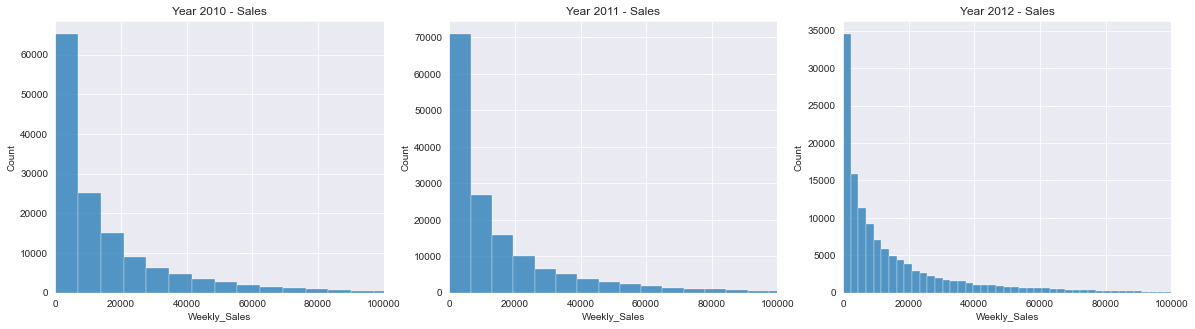

In [46]:
# We can see a log-normal trend
plot_data_2010 = dataset[dataset['year'] == 2010]
plot_data_2011 = dataset[dataset['year'] == 2011]
plot_data_2012 = dataset[dataset['year'] == 2012]


plt.figure(figsize = (20,5))
plt.subplot(1,3,1)
sns.histplot(data = plot_data_2010, x = 'Weekly_Sales', bins = 100)
plt.title('Year 2010 - Sales')
plt.xlim(0, 100000)
plt.xlabel('Weekly_Sales')
plt.subplot(1,3,2)
sns.histplot(data = plot_data_2011, x = 'Weekly_Sales', bins = 100)
plt.title('Year 2011 - Sales')
plt.xlim(0, 100000)
plt.xlabel('Weekly_Sales')
plt.subplot(1,3,3)
sns.histplot(data = plot_data_2012, x = 'Weekly_Sales', bins = 100)
plt.title('Year 2012 - Sales')
plt.xlim(0, 100000)
plt.xlabel('Weekly_Sales')
plt.show()

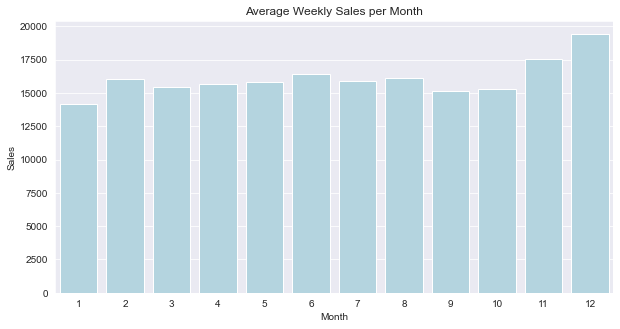

In [47]:
# Makes sense that there is more sales just before Christmas
month_sls = dataset.groupby('month')['Weekly_Sales'].mean()

plt.figure(figsize = (10,5))
sns.barplot(x = month_sls.index, y = month_sls.values, color = 'lightblue')
plt.title('Average Weekly Sales per Month')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()

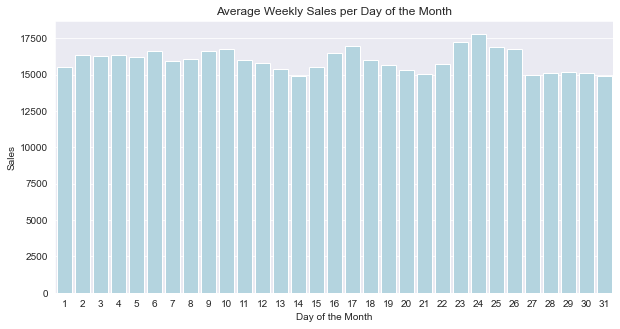

In [48]:
# Makes sense that there is not much explanatory power in the day of the month
weekday_sls = dataset.groupby('day_of_month')['Weekly_Sales'].mean()

plt.figure(figsize = (10,5))
sns.barplot(x = weekday_sls.index, y = weekday_sls.values, color = 'lightblue')
plt.title('Average Weekly Sales per Day of the Month')
plt.xlabel('Day of the Month')
plt.ylabel('Sales')
plt.show()

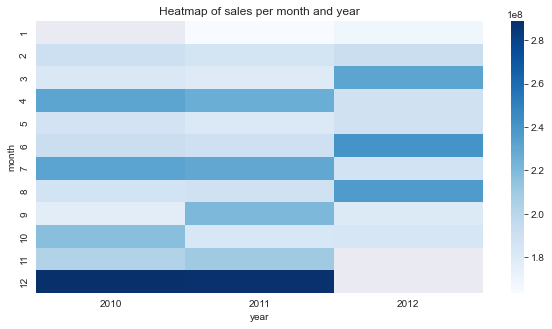

In [49]:
# The main explanatory value comes from the 12th month, with year not contributing much
plt.figure(figsize=(10, 5))
sns.heatmap(dataset.groupby(['month', 'year'])['Weekly_Sales'].sum().unstack(), cmap='Blues')
plt.title('Heatmap of sales per month and year')
plt.show()

### Merging data

In [50]:
dataset.head(2)

,Store,Dept,Date,Weekly_Sales,IsHoliday,year,month,day_of_month
0,1,1,2010-02-05,24924.50,False,2010,2,5
1,1,1,2010-02-12,46039.49,True,2010,2,12


In [51]:
features.head(2)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.57,NaN,NaN,NaN,NaN,NaN,211.10,8.11,False
1,1,2010-02-12,38.51,2.55,NaN,NaN,NaN,NaN,NaN,211.24,8.11,True


In [52]:
stores.head(2)

,Store,Type,Size
0,1,A,151315
1,2,A,202307


In [53]:
features_first_batch = features[features['Date'] < '2012-10-27']
features_second_batch = features[features['Date'] >= '2012-10-27']

In [54]:
data = pd.merge(dataset, features_first_batch, on = ['Store','Date','IsHoliday'], how = 'left')
data = pd.merge(data, stores, on = ['Store'], how = 'left')

In [55]:
data.head(2)

,Store,Dept,Date,Weekly_Sales,IsHoliday,year,month,day_of_month,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,2010,2,5,42.31,2.57,NaN,NaN,NaN,NaN,NaN,211.10,8.11,A,151315
1,1,1,2010-02-12,46039.49,True,2010,2,12,38.51,2.55,NaN,NaN,NaN,NaN,NaN,211.24,8.11,A,151315


Features_second_batch - we don't know weekly sales, so we cannot trian on that

Time Series forecasting

In [56]:
time_series = data.groupby(['Date'])['Weekly_Sales'].sum().reset_index()

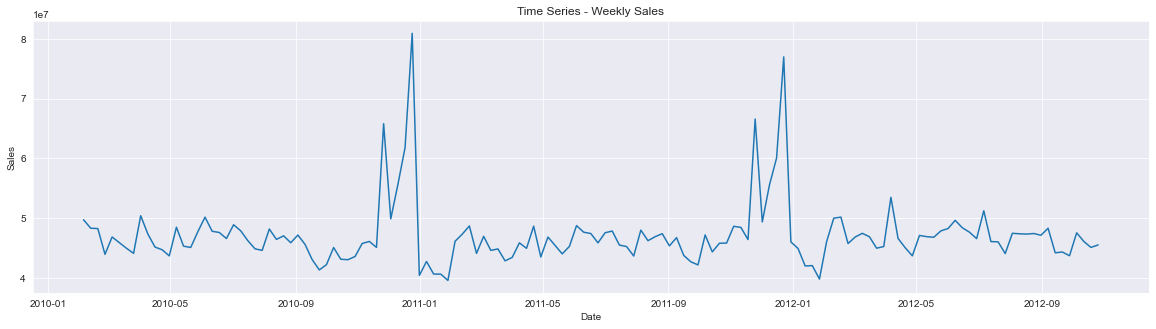

In [57]:
#Plot the time series
plt.figure(figsize=(20, 5))
plt.plot(time_series['Date'], time_series['Weekly_Sales'])
plt.title('Time Series - Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

# We can see that there is a spike in sales around Christmas, and this is especially true for the days just before the end of the year. It would make sense
# to create a variable for date-month 

In [58]:
data['Date_Month'] = data['Date'].apply(lambda _: _.strftime('%m-%d'))

In [59]:
data.head(2)

,Store,Dept,Date,Weekly_Sales,IsHoliday,year,month,day_of_month,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Date_Month
0,1,1,2010-02-05,24924.50,False,2010,2,5,42.31,2.57,NaN,NaN,NaN,NaN,NaN,211.10,8.11,A,151315,02-05
1,1,1,2010-02-12,46039.49,True,2010,2,12,38.51,2.55,NaN,NaN,NaN,NaN,NaN,211.24,8.11,A,151315,02-12


Because we will be using the model on the future data, we shouldn't take into account 'year' variable

In [60]:
data.drop(['year','Date'], axis = 1, inplace = True)
data.head(2)

,Store,Dept,Weekly_Sales,IsHoliday,month,day_of_month,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Date_Month
0,1,1,24924.50,False,2,5,42.31,2.57,NaN,NaN,NaN,NaN,NaN,211.10,8.11,A,151315,02-05
1,1,1,46039.49,True,2,12,38.51,2.55,NaN,NaN,NaN,NaN,NaN,211.24,8.11,A,151315,02-12


In [61]:
data.groupby(['Dept','Type'])['Dept'].count()

Dept  Type
1     A       3146
      B       2431
      C        858
2     A       3146
      B       2431
              ... 
98    B       1805
      C        858
99    A        822
      B         12
      C         19
Name: Dept, Length: 227, dtype: int64

### Benchmark model - Linear Regression

In [62]:
data.reset_index(inplace = True, drop = True)

In [63]:
# print the number of missing values in each column
for column in data.columns:
    print(column, data[column].isnull().sum())

Store 0
Dept 0
Weekly_Sales 0
IsHoliday 0
month 0
day_of_month 0
Temperature 0
Fuel_Price 0
MarkDown1 270085
MarkDown2 309367
MarkDown3 283618
MarkDown4 285750
MarkDown5 269337
CPI 0
Unemployment 0
Type 0
Size 0
Date_Month 0


Let's make a very simple model that will act as a lower benchmark

In [64]:
data

,Store,Dept,Weekly_Sales,IsHoliday,month,day_of_month,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Date_Month
0,1,1,24924.50,False,2,5,42.31,2.57,NaN,NaN,NaN,NaN,NaN,211.10,8.11,A,151315,02-05
1,1,1,46039.49,True,2,12,38.51,2.55,NaN,NaN,NaN,NaN,NaN,211.24,8.11,A,151315,02-12
2,1,1,41595.55,False,2,19,39.93,2.51,NaN,NaN,NaN,NaN,NaN,211.29,8.11,A,151315,02-19
3,1,1,19403.54,False,2,26,46.63,2.56,NaN,NaN,NaN,NaN,NaN,211.32,8.11,A,151315,02-26
4,1,1,21827.90,False,3,5,46.50,2.62,NaN,NaN,NaN,NaN,NaN,211.35,8.11,A,151315,03-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420280,45,98,508.37,False,9,28,64.88,4.00,4556.61,20.64,1.50,1601.01,3288.25,192.01,8.68,B,118221,09-28
420281,45,98,628.10,False,10,5,64.89,3.98,5046.74,NaN,18.82,2253.43,2340.01,192.17,8.67,B,118221,10-05
420282,45,98,1061.02,False,10,12,54.47,4.00,1956.28,NaN,7.89,599.32,3990.54,192.33,8.67,B,118221,10-12
420283,45,98,760.01,False,10,19,56.47,3.97,2004.02,NaN,3.18,437.73,1537.49,192.33,8.67,B,118221,10-19


In [65]:
X = data[['Store', 'Type','Size','Dept','IsHoliday','month','day_of_month','Temperature','Fuel_Price','CPI','Unemployment','Date_Month']].copy()
y = data['Weekly_Sales'].copy()

In [66]:
# create dummy variables
X = pd.get_dummies(X, columns = ['Store', 'Type','Dept','IsHoliday','month','day_of_month','Date_Month'], drop_first = True)

In [67]:
model = LinearRegression()

# Add 1 because we can't have 0 with log
y_log = np.log(y + 1)
model.fit(X, y_log)
y_fitted_log = model.predict(X)
y_fitted = np.exp(y_fitted_log) - 1

(-1000.0, 100000.0)

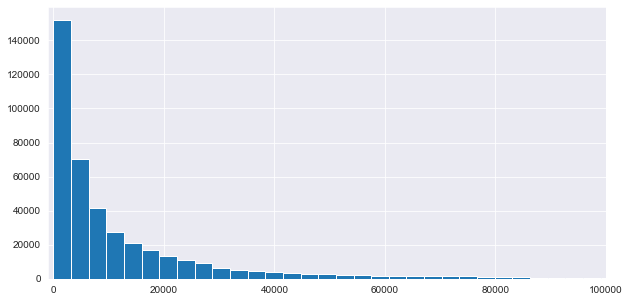

In [68]:
plt.hist(y_fitted, bins = 100)
plt.xlim(-1000, 100000)

In [69]:
# Weighted mean absolute error
def wmae(y, y_pred, weights):
    return np.sum(weights * np.abs(y - y_pred)) / np.sum(weights)

In [70]:
# w = 5 if the week is a holiday week, 1 otherwise
df = pd.DataFrame({'y_true': y, 'y_pred': y_fitted, 'weights': np.where(data['IsHoliday'] == True, 5, 1)}) 

y_true = df['y_true']
y_pred = df['y_pred']
weights = df['weights']

In [71]:
wmae_error = wmae(y_true, y_pred, weights).round(2)
print("LR WMAE: {:,.0f}".format(wmae_error))

LR WMAE: 7,294


In [72]:
lr_error = mean_squared_error(y_true, y_pred)
print("LR MSE: {:,.0f}".format(lr_error))

LR MSE: 203,099,449


### Second model: XGBoosting

In [73]:
data.head(2)

,Store,Dept,Weekly_Sales,IsHoliday,month,day_of_month,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Date_Month
0,1,1,24924.50,False,2,5,42.31,2.57,NaN,NaN,NaN,NaN,NaN,211.10,8.11,A,151315,02-05
1,1,1,46039.49,True,2,12,38.51,2.55,NaN,NaN,NaN,NaN,NaN,211.24,8.11,A,151315,02-12


In [74]:
# Add weight to the data
data['weights'] = np.where(data['IsHoliday'] == True, 5, 1)
data.head(2)

,Store,Dept,Weekly_Sales,IsHoliday,month,day_of_month,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Date_Month,weights
0,1,1,24924.50,False,2,5,42.31,2.57,NaN,NaN,NaN,NaN,NaN,211.10,8.11,A,151315,02-05,1
1,1,1,46039.49,True,2,12,38.51,2.55,NaN,NaN,NaN,NaN,NaN,211.24,8.11,A,151315,02-12,5


In [122]:
X = data.copy()
X.drop(['Weekly_Sales','Date_Month'], axis=1, inplace=True)
y = data['Weekly_Sales']

X = pd.get_dummies(X, columns = ['Store','Type','Dept','IsHoliday','month'], drop_first = True)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

train_weights = X_train['weights']
val_weights = X_val['weights']
X_train.drop(['weights'], axis=1, inplace=True)
X_val.drop(['weights'], axis=1, inplace=True)

We will use higher depth than 2, because there are interdependencies in the data

We want to optimize for weighted MAE, however, MAE is not continuously differentiable everywhere, so we should look at approximations of that loss function. MSE tends to approximate MAE quite well for small values, however, we want it to be a good approximation for larger values as well. Hence, we will instead use an approximation of Huber loss.

Defining an approximation of a weighted huber loss function

In [123]:
dtrain = xgb.DMatrix(X_train, label=y_train, weight=train_weights) 
dval = xgb.DMatrix(X_val, label=y_val, weight=val_weights) 


def weighted_huber_approx_obj(preds, dtrain):
    labels = dtrain.get_label()
    d = preds - labels
    h = 1  
    weights = dtrain.get_weight()  

    scale = weights * (1 + (d / h) ** 2)
    scale_sqrt = np.sqrt(scale)

    grad = weights * d / scale_sqrt
    hess = weights / scale / scale_sqrt

    return grad, hess

Train the model on all training data using best parameters discovered during cross validation

In [77]:
params = {'max_depth': 7,
          'seed' : 42,
          'booster' : 'gbtree',
          'tree_method' : 'hist',
          'learning_rate' : 0.5,
          }

bst = xgb.train(params=params, dtrain=dtrain, num_boost_round= 900, obj=weighted_huber_approx_obj)

# Predict on validation set
y_fitted = bst.predict(dval)

In [78]:
# Predict on validation set
y_fitted = bst.predict(dval)

In [79]:
xgb_error = mean_squared_error(y_val, y_fitted)
print("XGBoost MSE: {:,.0f}".format(xgb_error))

wmae_error = wmae(y_val, y_fitted, val_weights).round(2)
print("XGBoosting WMAE: {:,.0f}".format(wmae_error))

XGBoost MSE: 437,201,289
XGBoosting WMAE: 10,622


In [80]:
# Grid search
param_grid = {
    'n_estimators': [300, 700, 900],
    'learning_rate': [0.3, 0.5, 0.7],
    'max_depth': [3, 4, 5]
}

model = xgb.XGBRegressor(seed = 42, 
                         booster = 'gbtree',
                         objective = 'reg:squarederror',
                         tree_method = 'hist')

grid_search = GridSearchCV(estimator= model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1)

# Fit the grid search
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_params

Fitting 3 folds for each of 27 candidates, totalling 81 fits


/Users/anastasiamalakhova/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/anastasiamalakhova/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/anastasiamalakhova/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/anastasiamalakhova/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated an

{'learning_rate': 0.7, 'max_depth': 5, 'n_estimators': 900}

Applying best parameters from grid search

In [116]:
y_train_log = np.log(y_train + 1)

model = xgb.XGBRegressor(seed=42, 
                         booster = 'gbtree', 
                         objective = 'reg:squarederror', 
                         tree_method = 'hist',
                         learning_rate = 0.7, 
                         n_estimators = 900,
                         max_depth = 5)

model.fit(X_train, y_train_log)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.7, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=900, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=1, tree_method='hist', validate_parameters=1,
             verbosity=None)

In [117]:
y_log_fitted = model.predict(X_val)
y_fitted = np.exp(y_log_fitted) - 1

xgb_error = mean_squared_error(y_val, y_fitted)
print("XGBoost MSE: {:,.0f}".format(xgb_error))

XGBoost MSE: 16,698,229


In [118]:
wmae_error = wmae(y_val, y_fitted, val_weights).round(2)
print("XGBoosting WMAE: {:,.0f}".format(wmae_error))

XGBoosting WMAE: 1,778


In this case we see that training on MSE actually results in a better performance even when evaluated on the Weighted MAE metric. 

Retraining model on all data

In [124]:
columns_to_add = []
for column in X_train.columns:
    if column not in X.columns:
        print(column)
        columns_to_add.append(column)

In [125]:
columns_to_add = []
for column in X.columns:
    if column not in X_train.columns:
        print(column)
        columns_to_add.append(column)

weights


In [126]:
X_weights = X['weights']
X.drop('weights', axis = 1, inplace = True)

In [127]:
X.head(2)

,day_of_month,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,5,42.31,2.57,NaN,NaN,NaN,NaN,NaN,211.10,8.11,...,0,0,0,0,0,0,0,0,0,0
1,12,38.51,2.55,NaN,NaN,NaN,NaN,NaN,211.24,8.11,...,0,0,0,0,0,0,0,0,0,0


In [130]:
y_log = np.log(y + 1)

model.fit(X, y_log)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.7, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=900, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=1, tree_method='hist', validate_parameters=1,
             verbosity=None)

### Creating a test file

In [131]:
test = pd.read_csv('test.csv')
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [132]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Store      115064 non-null  int64 
 1   Dept       115064 non-null  int64 
 2   Date       115064 non-null  object
 3   IsHoliday  115064 non-null  bool  
dtypes: bool(1), int64(2), object(1)
memory usage: 2.7+ MB


In [133]:
test['Date'] = test['Date'].apply(lambda _: datetime.strptime(_,"%Y-%m-%d"))
test['month'] = test['Date'].apply(lambda _: _.month)
test['day_of_month'] = test['Date'].apply(lambda _: _.day)

In [134]:
test.head()

,Store,Dept,Date,IsHoliday,month,day_of_month
0,1,1,2012-11-02,False,11,2
1,1,1,2012-11-09,False,11,9
2,1,1,2012-11-16,False,11,16
3,1,1,2012-11-23,True,11,23
4,1,1,2012-11-30,False,11,30


Merging data together

In [135]:
test_data = pd.merge(test, features_second_batch, on=['Store', 'Date','IsHoliday'], how='left')
test_data = pd.merge(test_data, stores, on=['Store'], how='left')

In [136]:
test_data.head()

,Store,Dept,Date,IsHoliday,month,day_of_month,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2012-11-02,False,11,2,55.32,3.39,6766.44,5147.70,50.82,3639.90,2737.42,223.46,6.57,A,151315
1,1,1,2012-11-09,False,11,9,61.24,3.31,11421.32,3370.89,40.28,4646.79,6154.16,223.48,6.57,A,151315
2,1,1,2012-11-16,False,11,16,52.92,3.25,9696.28,292.10,103.78,1133.15,6612.69,223.51,6.57,A,151315
3,1,1,2012-11-23,True,11,23,56.23,3.21,883.59,4.17,74910.32,209.91,303.32,223.56,6.57,A,151315
4,1,1,2012-11-30,False,11,30,52.34,3.21,2460.03,NaN,3838.35,150.57,6966.34,223.61,6.57,A,151315


In [137]:
test_data['weights'] = np.where(test_data['IsHoliday'] == True, 5, 1)
test_data_weights = test_data['weights']
test_data.drop(['Date','weights'], axis = 1, inplace = True)

In [138]:
test_data = pd.get_dummies(test_data, columns = ['Store','Type','Dept','IsHoliday','month'], drop_first = True)

In [139]:
len(X.columns)

149

In [140]:
len(test_data.columns)

146

In [141]:
# Find columns that are present in X but not in test
columns_to_add = []
for column in X.columns:
    if column not in test_data.columns:
        print(column)
        columns_to_add.append(column)

month_8
month_9
month_10


In [142]:
for column in columns_to_add:
    test_data[column] = 0

In [143]:
# Find columns that are present in X_val but not in test
columns_to_add = []
for column in test_data.columns:
    if column not in X.columns:
        print(column)
        columns_to_add.append(column)

In [144]:
len(X_train.columns) == len(test_data.columns)

True

In [145]:
y_fitted_log = model.predict(test_data)
y_fitted = np.exp(y_fitted_log) - 1

Needed format

In [146]:
# Re-download test
test = pd.read_csv('test.csv')

In [147]:
# add y_fitted column
test['Id'] = test['Store'].astype(str) + '_' + test['Dept'].astype(str) + '_' + test['Date'].astype(str)
test['Weekly_Sales'] = y_fitted
test.drop(['Store','Dept','Date','IsHoliday'], axis = 1, inplace = True)
test.head()

,Id,Weekly_Sales
0,1_1_2012-11-02,15267.20
1,1_1_2012-11-09,15652.55
2,1_1_2012-11-16,15411.01
3,1_1_2012-11-23,18528.12
4,1_1_2012-11-30,15805.79


In [148]:
# Assuming df is your DataFrame
test.to_csv('to_submit.csv', index=False)